# Changes made to `joint_classifier`



*   Simplified the neural network architecture (2 hidden layers for the concept predictor and label predictor each instead of 3) to try to reduce overfitting
*   Early stopping: training stops if validation loss does not improve for 10 consecutive epochs to avoid overfitting
*   Includes a learning rate scheduler (StepLR) that reduces the learning rate by a factor of 0.1 every 10 epochs. This helps in fine-tuning the learning process.
*   The learning rate for the optimizer is decreased from 0.01 in to 0.001. A smaller learning rate can help in achieving a more stable and fine-grained convergence.


# Imports

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialise GPU

In [19]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading and Pre-processing

In [20]:
# Class for pre-processing the data
class MIMICDataProcessor:
    def __init__(self, file_path, batch_size=64):
        self.file_path = file_path
        self.batch_size = batch_size
        self.scaler = StandardScaler()

        # Load and preprocess the data
        self.df = pd.read_csv(file_path)
        # Replace all missing values with 0
        self.df.fillna(0, inplace=True)

        # Features
        self.X = self.df[['upper_respiratory_infections', 'influenza_pneumonia', 'acute_lower_respiratory_infections', 'chronic_lower_respiratory_diseases',
                          'lung_diseases_due_to_external_agents', 'other_respiratory_diseases', 'InvasiveVent', 'SupplementalOxygen', 'HFNC',
                          'NonInvasiveVent', 'Tracheostomy', 'None', 'avg_uo_24hr', 'avg_creatinine_max', 'max_renal_uo_24hr', 'max_renal_creatinine_max',
                          'avg_pao2fio2ratio_novent', 'avg_pao2fio2ratio_vent', 'max_respiration_pao2fio2ratio_novent', 'max_respiration_pao2fio2ratio_vent', 'avg_gcs_min', 'max_cns_gcs_min',
                          'sofa_score', 'suspected_infection', 'one_vasopressor', 'multi_vasopressor']]

        # Concepts
        self.C = self.df[['c_rsp_mod', 'c_rsp_svr', 'c_vent_low', 'c_vent_moderate', 'c_vent_high', 'c_max_renf_moderate', 'c_max_renf_severe',
                          'c_avg_renf_moderate', 'c_avg_renf_severe', 'c_max_respf_moderate', 'c_max_respf_severe', 'c_avg_respf_moderate',
                          'c_avg_respf_severe', 'c_max_cnsf_moderate', 'c_max_cnsf_severe', 'c_avg_cnsf_moderate', 'c_avg_cnsf_severe',
                          'c_sepsis3', 'c_shock']]

        # Label
        self.Y = self.df['ARDS']

        # Convert to tensors
        self.X_tensor = torch.tensor(self.X.values, dtype=torch.float32)
        self.C_tensor = torch.tensor(self.C.values, dtype=torch.float32)
        self.Y_tensor = torch.tensor(self.Y.values, dtype=torch.float32)

        # Normalize the features
        self.X_scaled = self.scaler.fit_transform(self.X)
        self.X_tensor_scaled = torch.tensor(self.X_scaled, dtype=torch.float32)

    def get_features(self):
        return self.X.columns.tolist()

    def get_concepts(self):
        return self.C.columns.tolist()

    def get_labels(self):
        return self.Y.columns.tolist()

    # Dataset class needed to provide the __getitem__ method for DataLoader
    class MIMICDataset(Dataset):
        def __init__(self, x, c, y):
            self.x = x
            self.c = c
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.x[idx], self.c[idx], self.y[idx]

    def create_dataloaders(self):
        # Split the data into temporary (80%) and test (20%) sets
        X_temp, X_test, C_temp, C_test, Y_temp, Y_test = train_test_split(
            self.X_tensor_scaled, self.C_tensor, self.Y_tensor, test_size=0.20, random_state=42)

        # Further split the temporary data into training (75% of temporary) and validation (25% of temporary) sets
        X_train, X_val, C_train, C_val, Y_train, Y_val = train_test_split(
            X_temp, C_temp, Y_temp, test_size=0.25, random_state=42)

        train_dataset = self.MIMICDataset(X_train, C_train, Y_train)
        val_dataset = self.MIMICDataset(X_val, C_val, Y_val)
        test_dataset = self.MIMICDataset(X_test, C_test, Y_test)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader

# Model

In [21]:
class MultiLabelNN(nn.Module):
    def __init__(self, num_features, num_concepts, num_labels):
        super(MultiLabelNN, self).__init__()
        # Layers to predict concepts
        self.layer1 = nn.Linear(num_features, 32)
        self.layer2 = nn.Linear(32, 64)
        self.concept_output_layer = nn.Linear(64, num_concepts)

        # Layers to predict final output from concepts
        self.layer4 = nn.Linear(num_concepts, 32)
        self.layer5 = nn.Linear(32, 64)
        self.label_output_layer = nn.Linear(64, num_labels)

    def forward(self, x):
        # Layers for concept prediction
        x_c = torch.relu(self.layer1(x))
        x_c = torch.relu(self.layer2(x_c))
        intermediate_output = self.concept_output_layer(x_c)
        intermediate_probability = torch.sigmoid(intermediate_output)

        # Layers for label prediction
        x = torch.relu(intermediate_output)
        x = torch.relu(self.layer4(x))
        x = torch.relu(self.layer5(x))
        final_probability = torch.sigmoid(self.label_output_layer(x))

        return intermediate_probability, final_probability

# Training

Look at the Step 5 from this [basic code](https://colab.research.google.com/drive/1LqE89tPVt6h1wa7lerLgF4GNvRw9QFDw?usp=sharing) for reference.

In [22]:
def train(x_size, c_size, y_size, x_to_y_learning_rate, lamda, epochs, train_loader, val_loader):
    torch.manual_seed(25)

    x_to_y = MultiLabelNN(num_features=x_size, num_concepts=c_size, num_labels=y_size).to(device)

    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for classification
    x_to_y_optimizer = torch.optim.Adam(x_to_y.parameters(), lr=x_to_y_learning_rate)
    x_to_y_scheduler = StepLR(x_to_y_optimizer, step_size=10, gamma=0.1)

    epochs_count = []
    x_to_c_loss_values, c_to_y_loss_values, total_loss_values = [], [], []
    x_to_c_predictions, c_to_y_predictions = [], []
    x_to_c_val_loss_values, c_to_y_val_loss_values, total_val_loss_values = [], [], []
    x_to_c_val_predictions, c_to_y_val_predictions = [], []
    ground_truth_val_c, ground_truth_val_y = [], []

    best_test_loss = float('inf')
    patience, trials = 10, 0

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")  # Print current epoch
        epochs_count.append(epoch)

        # Training Loop
        x_to_y.train()

        running_x_to_c_loss, running_c_to_y_loss = 0.0, 0.0
        running_total_loss = 0.0
        total_samples = 0

        for i, batch in enumerate(train_loader):
            x, c, y = batch
            x, c, y = x.to(device), c.to(device), y.to(device)

            # Forward pass through x_to_y
            x_to_y_optimizer.zero_grad()
            x = x.to(x_to_y.layer1.weight.dtype)  # ensure data type of input tensor x matches data type of weights of the first linear layer
            predicted_c, predicted_y = x_to_y(x)

            # Squeeze the predictions to match the target dimensions
            predicted_c = predicted_c.squeeze()
            predicted_y = predicted_y.squeeze()

            x_to_c_predictions.append(predicted_c.detach().cpu().numpy())
            c_to_y_predictions.append(predicted_y.detach().cpu().numpy())

            c_loss = criterion(predicted_c, c.float())
            y_loss = criterion(predicted_y, y.float())

            # Combined loss
            total_loss = c_loss + lamda * y_loss

            # Backward pass and optimisation for combined loss
            total_loss.backward()
            x_to_y_optimizer.step()

            # Accumulate loss values
            running_x_to_c_loss += c_loss.item()
            running_c_to_y_loss += y_loss.item()
            running_total_loss += total_loss.item()

            total_samples += len(y)

        x_to_c_loss_values.append(running_x_to_c_loss / len(train_loader))
        c_to_y_loss_values.append(running_c_to_y_loss / len(train_loader))
        total_loss_values.append(running_total_loss / len(train_loader))

        # Step the schedulers
        x_to_y_scheduler.step()

        # Validating Loop
        x_to_y.eval()

        running_x_to_c_val_loss, running_c_to_y_val_loss = 0.0, 0.0
        running_total_val_loss = 0.0
        total_val_samples = 0

        with torch.no_grad():
            for x, c, y in val_loader:
                # GPU
                x, c, y = x.to(device), c.to(device), y.to(device)

                # Ground truth array
                ground_truth_val_c.append(c.cpu())
                ground_truth_val_y.append(y.cpu())

                # Forward pass through x_to_y
                x = x.to(x_to_y.layer1.weight.dtype)  # ensure data type of input tensor x matches data type of weights of the first linear layer
                predicted_c, predicted_y = x_to_y(x)

                # Squeeze the predictions to match the target dimensions
                predicted_c = predicted_c.squeeze()
                predicted_y = predicted_y.squeeze()

                x_to_c_val_predictions.append(predicted_c.detach().cpu().numpy())
                c_to_y_val_predictions.append(predicted_y.detach().cpu().numpy())

                c_loss = criterion(predicted_c, c.float())
                y_loss = criterion(predicted_y, y.float())

                total_loss = c_loss + lamda * y_loss

                # Accumulate loss values for valing
                running_x_to_c_val_loss += c_loss.item()
                running_c_to_y_val_loss += y_loss.item()
                running_total_val_loss += total_loss.item()

                total_val_samples += len(y)

        x_to_c_val_loss_values.append(running_x_to_c_val_loss / len(val_loader))
        c_to_y_val_loss_values.append(running_c_to_y_val_loss / len(val_loader))
        total_val_loss_values.append(running_total_val_loss / len(val_loader))

        # Early stopping
        if running_c_to_y_val_loss / len(val_loader) < best_test_loss:
            best_test_loss = running_c_to_y_val_loss / len(val_loader)
            trials = 0
        else:
            trials += 1
            if trials >= patience:
                print("Early stopping")
                break

    return (x_to_y, epochs_count, x_to_c_loss_values, c_to_y_loss_values, total_loss_values, x_to_c_predictions, c_to_y_predictions, x_to_c_val_loss_values, c_to_y_val_loss_values, total_val_loss_values, x_to_c_val_predictions, c_to_y_val_predictions, ground_truth_val_c, ground_truth_val_y)

In [23]:
# Specify Parameters
x_size = 26
c_size = 19
y_size = 1
x_to_y_learning_rate = 0.001
lamda = 0.3
epochs = 100

# Load Data
file_path = '/content/ards6-total.csv'
data_processor = MIMICDataProcessor(file_path, batch_size=64)
train_loader, test_loader, val_loader = data_processor.create_dataloaders()

x_to_y, epochs_count, x_to_c_loss_values, c_to_y_loss_values, total_loss_values, x_to_c_predictions, c_to_y_predictions, x_to_c_val_loss_values, c_to_y_val_loss_values, total_val_loss_values, x_to_c_val_predictions, c_to_y_val_predictions, ground_truth_val_c, ground_truth_val_y = train(x_size, c_size, y_size, x_to_y_learning_rate, lamda, epochs, train_loader, val_loader)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Early stopping


# Plotting Loss

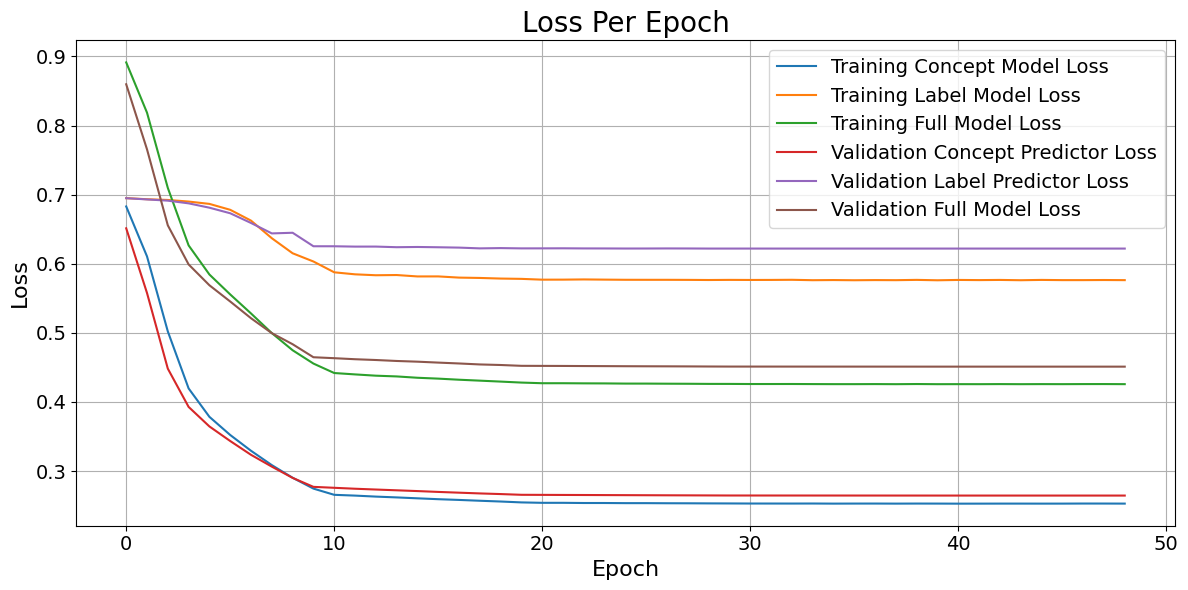

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_loss_values, label='Training Concept Model Loss')
plt.plot(epochs_count, c_to_y_loss_values, label='Training Label Model Loss')
plt.plot(epochs_count, total_loss_values, label='Training Full Model Loss')
plt.plot(epochs_count, x_to_c_val_loss_values, label='Validation Concept Predictor Loss')
plt.plot(epochs_count, c_to_y_val_loss_values, label='Validation Label Predictor Loss')
plt.plot(epochs_count, total_val_loss_values, label='Validation Full Model Loss')
plt.title('Loss Per Epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('ards-joint-es.png')
plt.show()

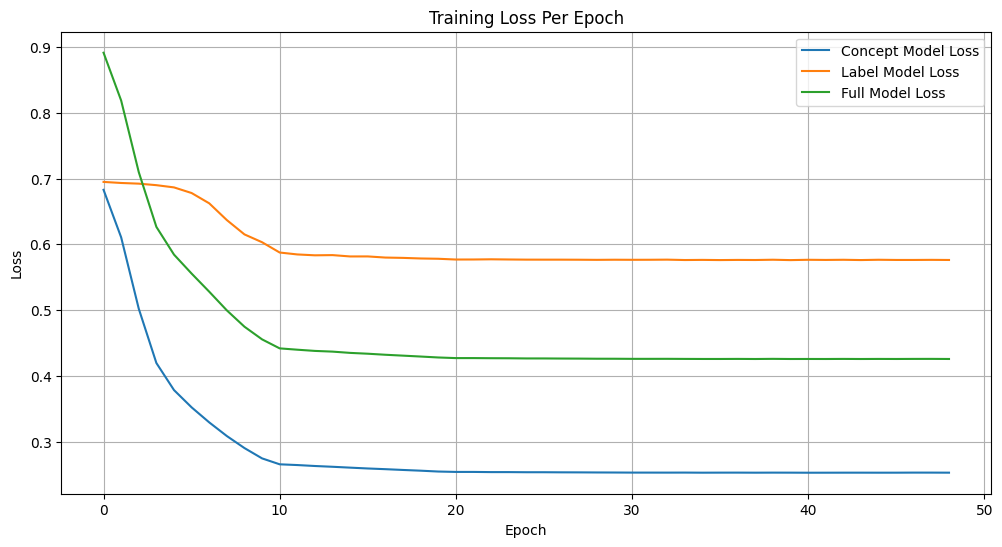

In [25]:
# Training loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_loss_values, label='Concept Model Loss')
plt.plot(epochs_count, c_to_y_loss_values, label='Label Model Loss')
plt.plot(epochs_count, total_loss_values, label='Full Model Loss')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

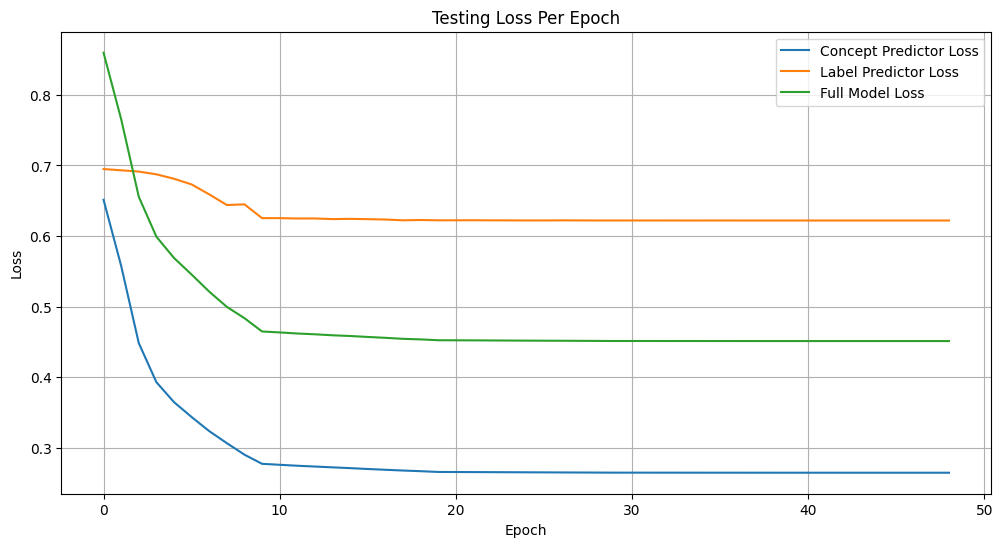

In [26]:
# Testing loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_val_loss_values, label='Concept Predictor Loss')
plt.plot(epochs_count, c_to_y_val_loss_values, label='Label Predictor Loss')
plt.plot(epochs_count, total_val_loss_values, label='Full Model Loss')
plt.title('Testing Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Validation Evaluation

In [27]:
def evaluate_concept_predictor(ground_truth_c, x_to_c_predictions, concept_labels):
    results = []
    precisions = []
    recalls = []
    f1_scores = []
    aucs = []
    accuracies = []

    for i, label in enumerate(concept_labels):
        true_values = torch.cat([c[:, i] if isinstance(c, torch.Tensor) else torch.tensor(c[:, i]) for c in ground_truth_c]).numpy()
        predicted_values = torch.cat([c[:, i] if isinstance(c, torch.Tensor) else torch.tensor(c[:, i]) for c in x_to_c_predictions]).numpy()

        predicted_classes = (predicted_values > 0.5).astype(int)  # Convert probabilities to binary classes

        precision = precision_score(true_values, predicted_classes, zero_division=0)
        recall = recall_score(true_values, predicted_classes, zero_division=0)
        f1 = f1_score(true_values, predicted_classes, zero_division=0)
        # Check if both classes are present in true_values before calculating AUC
        if len(np.unique(true_values)) == 2:
            auc = roc_auc_score(true_values, predicted_classes)
        else:
            auc = None
        accuracy = accuracy_score(true_values, predicted_classes)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        aucs.append(auc if auc is not None else 0)  # Use 0 or another value for averaging
        accuracies.append(accuracy)

        results.append({
            "Label": label,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "AUC": auc,
            "Accuracy": accuracy
        })

    # Calculate the average values for each metric, excluding None values for AUC
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)
    avg_auc = np.mean([auc for auc in aucs if auc is not None])
    avg_accuracy = np.mean(accuracies)

    # Append the average values to the results
    results.append({
        "Label": "Average",
        "Precision": avg_precision,
        "Recall": avg_recall,
        "F1 Score": avg_f1,
        "AUC": avg_auc,
        "Accuracy": avg_accuracy
    })

    return pd.DataFrame(results)

In [28]:
# Get concept labels from the data processor
concept_labels = data_processor.get_concepts()

# Evaluation
concept_predictor_results = evaluate_concept_predictor(ground_truth_val_c, x_to_c_val_predictions, concept_labels)
print("Validation Concept Predictor Results:")
print(concept_predictor_results)

Validation Concept Predictor Results:
                   Label  Precision    Recall  F1 Score       AUC  Accuracy
0              c_rsp_mod   0.793585  0.988146  0.880242  0.612320  0.798841
1              c_rsp_svr   0.989088  0.315829  0.478778  0.657472  0.860771
2             c_vent_low   0.894499  0.991166  0.940355  0.832794  0.907483
3        c_vent_moderate   1.000000  0.424036  0.595541  0.712018  0.923205
4            c_vent_high   0.995061  0.999848  0.997449  0.499924  0.994911
5    c_max_renf_moderate   0.703297  0.206230  0.318937  0.581844  0.710758
6      c_max_renf_severe   0.850720  0.749366  0.796833  0.819395  0.825447
7    c_avg_renf_moderate   0.272727  0.002187  0.004338  0.500877  0.930612
8      c_avg_renf_severe   0.679511  0.295102  0.411497  0.637749  0.895792
9   c_max_respf_moderate   0.031250  0.001020  0.001976  0.499689  0.949106
10    c_max_respf_severe   0.950617  1.000000  0.974684  0.500000  0.950617
11  c_avg_respf_moderate   0.622687  0.438881  0.5

In [29]:
# Label Predictor Evaluation
def evaluate_label_predictor(ground_truth_y, c_to_y_predictions):
    # Ensure all elements are tensors
    ground_truth_y = [torch.tensor(gy) if not isinstance(gy, torch.Tensor) else gy for gy in ground_truth_y]
    c_to_y_predictions = [torch.tensor(py) if not isinstance(py, torch.Tensor) else py for py in c_to_y_predictions]

    true_values = torch.cat(ground_truth_y).numpy()
    predicted_values = torch.cat(c_to_y_predictions).squeeze().numpy()

    predicted_classes = (predicted_values > 0.5).astype(int)  # Convert probabilities to binary classes

    precision = precision_score(true_values, predicted_classes)
    recall = recall_score(true_values, predicted_classes)
    f1 = f1_score(true_values, predicted_classes)
    auc = roc_auc_score(true_values, predicted_classes)
    accuracy = accuracy_score(true_values, predicted_classes)

    results = {"Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Accuracy": accuracy}

    index = pd.Index(["Metrics"])
    return pd.DataFrame(results, index=index)

In [30]:
# Evaluation
print("Validation Label Predictor Results:")
label_predictor_results = evaluate_label_predictor(ground_truth_val_y, c_to_y_val_predictions)
print(label_predictor_results)

Validation Label Predictor Results:
         Precision    Recall  F1 Score       AUC  Accuracy
Metrics    0.66206  0.612733  0.636442  0.639613   0.63875


# Testing Evaluation

In [31]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for classification

    running_x_to_c_test_loss, running_c_to_y_test_loss = 0.0, 0.0
    running_total_test_loss = 0.0
    total_test_samples = 0
    ground_truth_test_c, ground_truth_test_y = [], []
    x_to_c_test_predictions, c_to_y_test_predictions = [], []

    with torch.no_grad():
        for x, c, y in test_loader:
            # GPU
            x, c, y = x.to(device), c.to(device), y.to(device)

            # Ground truth array
            ground_truth_test_c.append(c.cpu())
            ground_truth_test_y.append(y.cpu())

            # Forward pass through the model
            x = x.to(model.layer1.weight.dtype)  # ensure data type of input tensor x matches data type of weights of the first linear layer
            predicted_c, predicted_y = model(x)

            # Squeeze the predictions to match the target dimensions
            predicted_c = predicted_c.squeeze()
            predicted_y = predicted_y.squeeze()

            x_to_c_test_predictions.append(predicted_c.detach().cpu().numpy())
            c_to_y_test_predictions.append(predicted_y.detach().cpu().numpy())

            c_loss = criterion(predicted_c, c.float())
            y_loss = criterion(predicted_y, y.float())

            total_loss = c_loss + y_loss

            # Accumulate loss values for testing
            running_x_to_c_test_loss += c_loss.item()
            running_c_to_y_test_loss += y_loss.item()
            running_total_test_loss += total_loss.item()

            total_test_samples += len(y)

    print(f'Test Concept Predictor Loss: {running_x_to_c_test_loss / len(test_loader):.4f}')
    print(f'Test Label Predictor Loss: {running_c_to_y_test_loss / len(test_loader):.4f}')
    print(f'Test Total Loss: {running_total_test_loss / len(test_loader):.4f}')

    return ground_truth_test_c, ground_truth_test_y, x_to_c_test_predictions, c_to_y_test_predictions


In [32]:
# Call the test function and print the results
ground_truth_test_c, ground_truth_test_y, x_to_c_test_predictions, c_to_y_test_predictions = test_model(x_to_y, test_loader)

Test Concept Predictor Loss: 0.2525
Test Label Predictor Loss: 0.6253
Test Total Loss: 0.8779


In [33]:
# Evaluate and print test results for the concept predictor
concept_test_results = evaluate_concept_predictor(ground_truth_test_c, x_to_c_test_predictions, concept_labels)
print("Test Concept Predictor Results:")
print(concept_test_results)

Test Concept Predictor Results:
                   Label  Precision    Recall  F1 Score       AUC  Accuracy
0              c_rsp_mod   0.836461  0.996805  0.909621  0.663238  0.846535
1              c_rsp_svr   0.964286  0.355263  0.519231  0.676107  0.876238
2             c_vent_low   0.944785  0.993548  0.968553  0.901030  0.950495
3        c_vent_moderate   0.969697  0.603774  0.744186  0.800462  0.945545
4            c_vent_high   0.997525  1.000000  0.998761  0.500000  0.997525
5    c_max_renf_moderate   0.705882  0.180451  0.287425  0.571775  0.705446
6      c_max_renf_severe   0.830601  0.775510  0.802111  0.813236  0.814356
7    c_avg_renf_moderate   0.000000  0.000000  0.000000  0.500000  0.891089
8      c_avg_renf_severe   0.741935  0.410714  0.528736  0.693863  0.898515
9   c_max_respf_moderate   0.000000  0.000000  0.000000  0.500000  0.957921
10    c_max_respf_severe   0.957921  1.000000  0.978508  0.500000  0.957921
11  c_avg_respf_moderate   0.760870  0.630631  0.689655 

In [34]:
# Evaluate and print test results for the label predictor
label_test_results = evaluate_label_predictor(ground_truth_test_y, c_to_y_test_predictions)
print("Test Label Predictor Results:")
print(label_test_results)

Test Label Predictor Results:
         Precision    Recall  F1 Score       AUC  Accuracy
Metrics   0.647059  0.654054  0.650538  0.676342  0.678218
